Aim : Reproduce figure 2 and 3 from https://pubs.aip.org/aip/app/article/5/12/121301/123226/Generation-of-280-THz-spanning-near-ultraviolet


Z-cut LN: TE mode use No,and TM mode use No
T height : 600
r height: 100
width : 600-2100nm, steps 100
side-wall angle: 70 degree
sio2 bottom cladding

For z-CUT LNOI: no for the quasi-TE mode and ne for the quasi-TM mode, despite propagation direction

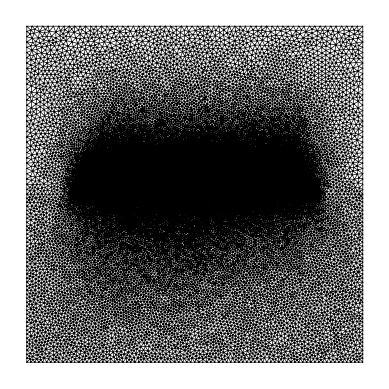

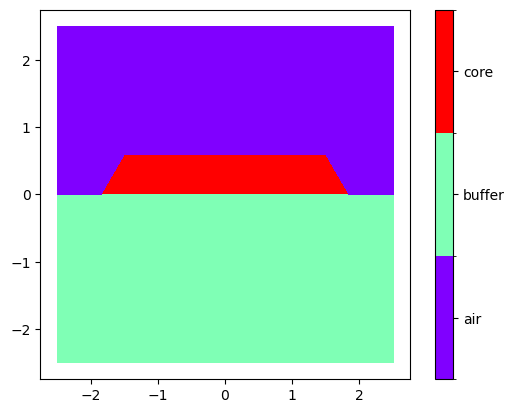

start


  0%|          | 0/1 [00:00<?, ?it/s]

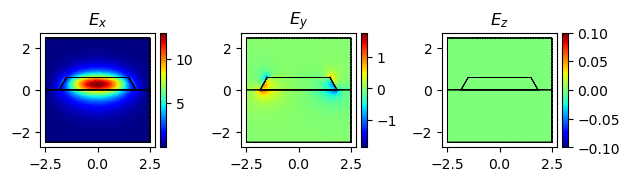

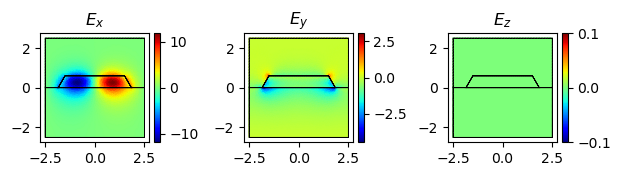

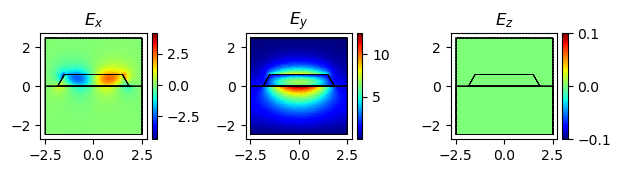

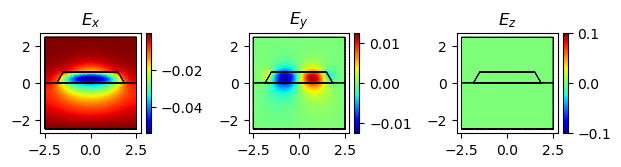

100%|██████████| 1/1 [00:42<00:00, 42.81s/it]

[5.27544458]
[1.46871125]
[2.51964452]
[1.71482123]


In [1]:

import math

from skfem import Basis, ElementTriP0
from tqdm import tqdm
from femwell.mesh import mesh_from_OrderedDict
from skfem.io import from_meshio
from femwell.visualization import plot_domains
import shapely
from femwell.maxwell.waveguide import compute_modes
from refractive_index import n_SiO2, n_Air, n_LNOI
from collections import OrderedDict
import numpy as np
from matplotlib import pyplot as plt
from shapely.geometry import Polygon

wavelength_range = [500, 3100]
wavelegnth_step = 70
ray = "o"

n_core = lambda w: n_LNOI(w, ray=ray)
n_buffer = n_SiO2
n_air = n_Air

# waveguide parameters
#bottom_width = 2 # um
top_width = 3
box_height = 5
triangle_height = 0.6
triangle_width = triangle_height/ math.tan(60 * math.pi /180)

# Construct waveguide geometry
"""
core = Polygon([(bottom_width/2,0 ),(-bottom_width/2, 0),(-bottom_width/2 + triangle_width, triangle_height) , (bottom_width/2 - triangle_width, triangle_height)])
buffer = shapely.geometry.box(-box_height/2,-box_height/2,box_height/2,0)
air = shapely.geometry.box(-box_height/2,0,box_height/2,box_height/2)
"""
core = Polygon([(top_width/2 + triangle_width,0 ),(-top_width/2-triangle_width, 0),(-top_width/2, triangle_height) , (top_width/2, triangle_height)])
buffer = shapely.geometry.box(-box_height/2,-box_height/2,box_height/2,0)
air = shapely.geometry.box(-box_height/2,0,box_height/2,box_height/2)

polygon = OrderedDict(
    core = core,
    buffer = buffer,
    air= air
)

# Define material property and resolution of waveguide
resolutions = dict(core={"resolution": 0.02, "distance": 0.1},
                   buffer={"resolution": 0.06, "distance": 0.5},
                   air={"resolution": 0.08, "distance": 0.5})

n_dict = {"core": n_core, "buffer": n_buffer, "air": n_air}

mesh = from_meshio(mesh_from_OrderedDict(polygon, resolutions))
mesh.draw().show()
plot_domains(mesh)
plt.show()

#----------------------FEM solver-------------------------------
print("start")
# Calculate dispersion and gamma
mesh = from_meshio(mesh_from_OrderedDict(polygon, resolutions))
basis0 = Basis(mesh, ElementTriP0())
epsilon = basis0.zeros()
wavelength_list = np.array([3000])
neff_list_te = []
aeff_list_te = []
neff_list_tm = []
aeff_list_tm = []

for wavelength in tqdm(wavelength_list):
    wavelength = wavelength * 1e-3
    for subdomain, n in n_dict.items():
        epsilon[basis0.get_dofs(elements=subdomain)] = n(wavelength) ** 2
    modes = compute_modes(basis0, epsilon, wavelength=wavelength, num_modes=3, order=1)
    
    ## te mode
    modes_sorted = modes.sorted(key=lambda mode: -np.real(mode.n_eff))
    mode = modes_sorted[0]
    neff_list_te.append(np.real(mode.n_eff))
    aeff_list_te.append(mode.calculate_effective_area())
    mode.show(mode.E.real, direction = "x")
    modes_sorted[1].show(modes_sorted[1].E.real, direction = "x")
    modes_sorted[2].show(modes_sorted[2].E.real, direction = "x")

    ## tm mode
    modes_sorted = modes.sorted(key=lambda mode: -np.real(mode.tm_fraction))
    if modes_sorted[0].tm_fraction < 0.7:
        print(f"at {wavelength}um, mode has highest tm_fraction of f{modes_sorted[0].tm_fraction}")
    mode = modes_sorted[0]
    neff_list_tm.append(np.real(mode.n_eff))
    aeff_list_tm.append(mode.calculate_effective_area())
    mode.show(mode.H.real, direction = "x")

neff_list_te = np.array(neff_list_te)
aeff_list_te = np.array(aeff_list_te)

neff_list_tm = np.array(neff_list_tm)
aeff_list_tm = np.array(aeff_list_tm)
wls = np.array(wavelength_list)
print(aeff_list_tm)
print(neff_list_tm)
print(aeff_list_te)
print(neff_list_te)


Plot the effective refractive index and calculate the GVD and dispersion operator

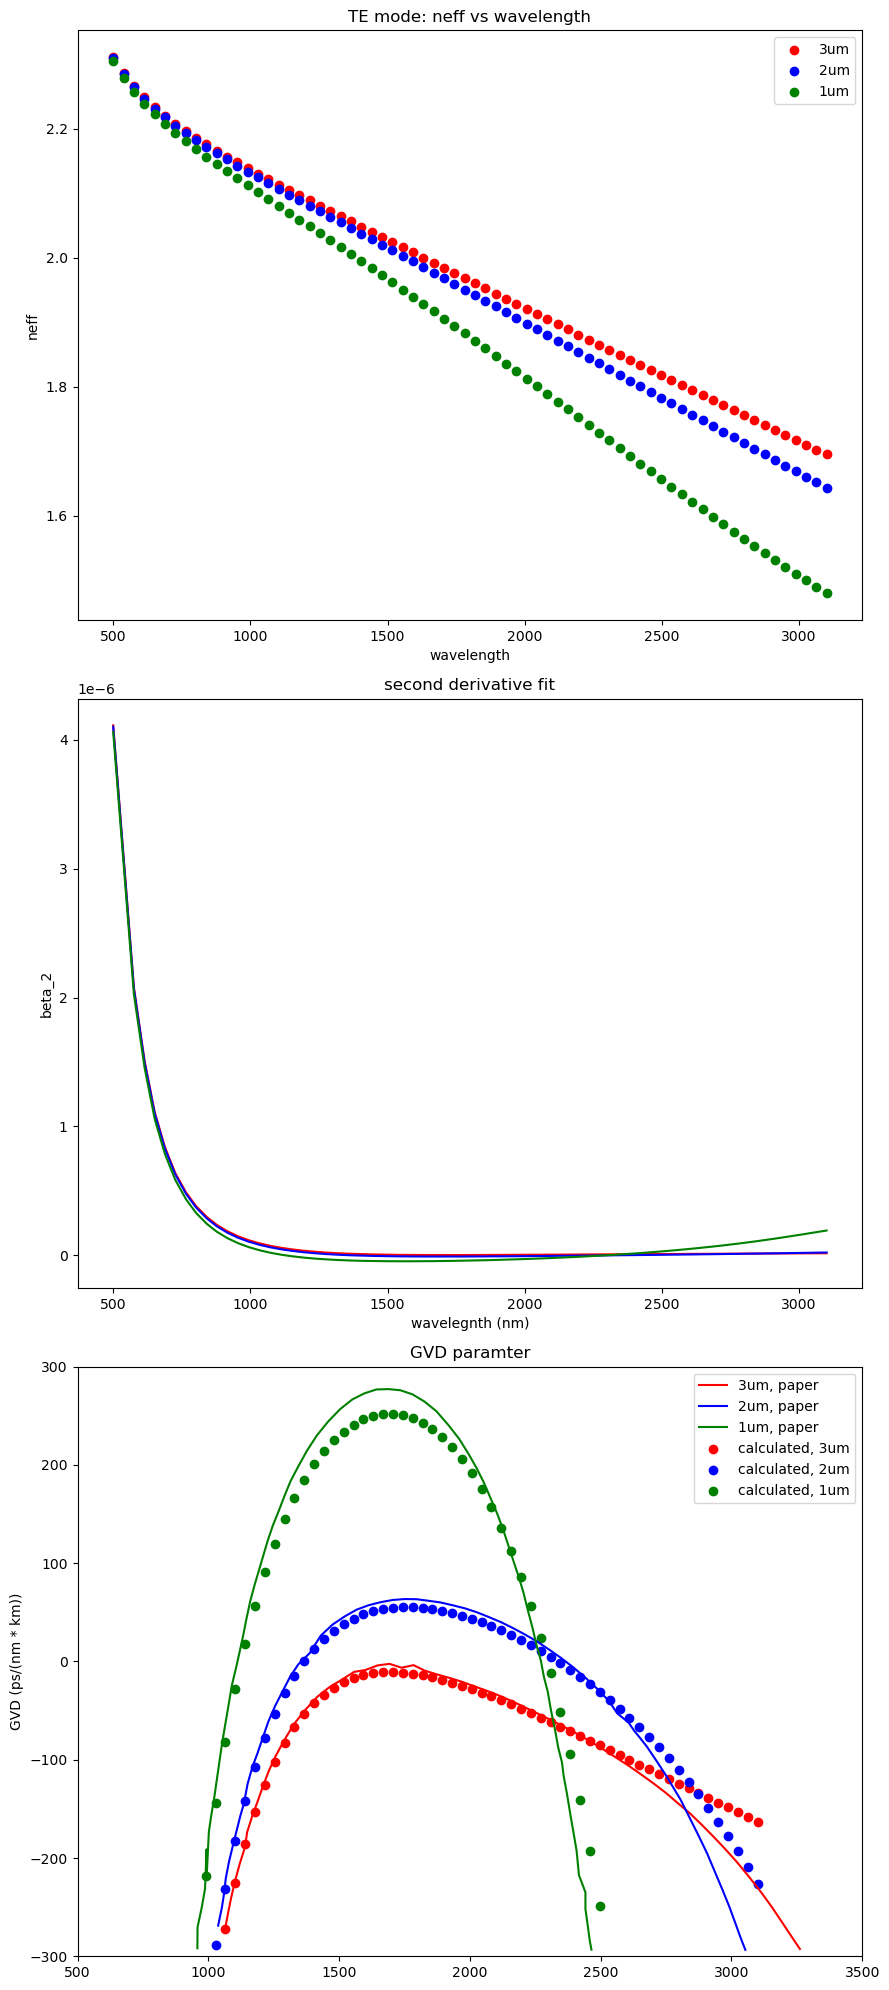

In [18]:
from numpy.polynomial import Polynomial
import numpy as np
import matplotlib.pyplot as plt
from refractive_index import n_Si3N4
from scipy.interpolate import UnivariateSpline
from scipy.constants import speed_of_light as c
import pandas as pd

top_width = 2
box_height = 5
triangle_height = 0.6

data_2um = np.load(f"data_h_{0.6}_w_{2}_o.npz")
data_1um = np.load(f"data_h_{0.6}_w_{1}_o.npz")
data_3um = np.load(f"data_h_{0.6}_w_{3}_o.npz")

neff_list_3um = np.array(np.real(data_3um['neff_list_te']))
neff_list_2um = np.array(np.real(data_2um['neff_list_te']))
neff_list_1um = np.array(np.real(data_1um['neff_list_te']))

wls_3um = data_3um["wls"]
wls_2um = data_2um["wls"]
wls_1um = data_1um["wls"]

fig, axs = plt.subplots(3, 1, figsize=(9,20))

#-----------fit neff spline----------------------------------
y_spl_3um = UnivariateSpline(wls_3um,neff_list_3um,s=0,k=3)
y_spl_2um = UnivariateSpline(wls_2um,neff_list_2um,s=0,k=3)
y_spl_1um = UnivariateSpline(wls_1um,neff_list_1um,s=0,k=3)
w_range = np.linspace(wls_2um[0],wls_2um[-1],1000)

#-----------neff plot-----------------
axs[0].set_xlabel("wavelength")
axs[0].set_ylabel("neff")
axs[0].set_title("TE mode: neff vs wavelength")
axs[0].scatter(wls_3um,neff_list_3um, color="red", label = "3um")
axs[0].scatter(wls_2um,neff_list_2um, color="blue", label = "2um")
axs[0].scatter(wls_1um,neff_list_1um, color="green", label = "1um")
axs[0].legend()

#-----------second derivative plot-----------------
y_spl_2d_3um = y_spl_3um.derivative(n=2)
y_spl_2d_2um = y_spl_2um.derivative(n=2)
y_spl_2d_1um = y_spl_1um.derivative(n=2)
axs[1].set_xlabel("wavelegnth (nm)")
axs[1].set_ylabel("beta_2")
axs[1].set_title("second derivative fit")
axs[1].plot(w_range,y_spl_2d_3um(w_range) , color="red")
axs[1].plot(w_range,y_spl_2d_2um(w_range) , color="blue")
axs[1].plot(w_range,y_spl_2d_1um(w_range) , color="green")


#-----------plot reference data __________________
ref_3um = pd.read_csv("../reference_data/3um.csv", dtype=np.float64)
ref_3um_x, ref_3um_y = np.split(ref_3um.values, 2, axis=1)
axs[2].plot(ref_3um_x, ref_3um_y, c="red", label = "3um, paper")

ref_2um = pd.read_csv("../reference_data/2um.csv", dtype=np.float64)
ref_2um_x, ref_2um_y = np.split(ref_2um.values, 2, axis=1)
axs[2].plot(ref_2um_x, ref_2um_y, c="blue", label = "2um, paper")

ref_1um = pd.read_csv("../reference_data/1um.csv", dtype=np.float64)
ref_1um_x, ref_1um_y = np.split(ref_1um.values, 2, axis=1)
axs[2].plot(ref_1um_x, ref_1um_y, c="green", label = "1um, paper")
#-----------GVD plot---------------------------
GVD_3um=(-wls_3um/(2.99792e-7 ) * y_spl_2d_3um(wls_3um))
GVD_2um=(-wls_2um/(2.99792e-7 ) * y_spl_2d_2um(wls_2um))
GVD_1um=(-wls_1um/(2.99792e-7 ) * y_spl_2d_1um(wls_2um))

axs[2].scatter(wls_3um, GVD_3um, label = "calculated, 3um", c="red")
axs[2].scatter(wls_2um, GVD_2um, label = "calculated, 2um", c="blue")
axs[2].scatter(wls_1um, GVD_1um, label = "calculated, 1um", c="green")

axs[2].set_ylabel("GVD (ps/(nm * km))")
axs[2].set_ylim(-300,300)
axs[2].set_xlim(500,3500)
axs[2].set_title("GVD paramter")
axs[2].legend()

plt.tight_layout()
plt.show()

-627.0253474358974, 1011.2746525641027
   1.0% - 1.010e-04 m - 0.0 seconds
   2.0% - 2.020e-04 m - 0.0 seconds
   3.0% - 3.030e-04 m - 0.0 seconds
   4.0% - 4.040e-04 m - 0.0 seconds
   5.1% - 5.051e-04 m - 0.0 seconds
   6.1% - 6.061e-04 m - 0.0 seconds
   7.1% - 7.071e-04 m - 0.0 seconds
   8.1% - 8.081e-04 m - 0.0 seconds
   9.1% - 9.091e-04 m - 0.0 seconds
  10.1% - 1.010e-03 m - 0.0 seconds
  11.1% - 1.111e-03 m - 0.0 seconds
  12.1% - 1.212e-03 m - 0.0 seconds
  13.1% - 1.313e-03 m - 0.1 seconds
  14.1% - 1.414e-03 m - 0.1 seconds
  15.2% - 1.515e-03 m - 0.1 seconds
  16.2% - 1.616e-03 m - 0.1 seconds
  17.2% - 1.717e-03 m - 0.1 seconds
  18.2% - 1.818e-03 m - 0.1 seconds
  19.2% - 1.919e-03 m - 0.1 seconds
  20.2% - 2.020e-03 m - 0.1 seconds
  21.2% - 2.121e-03 m - 0.1 seconds
  22.2% - 2.222e-03 m - 0.1 seconds
  23.2% - 2.323e-03 m - 0.1 seconds
  24.2% - 2.424e-03 m - 0.1 seconds
  25.3% - 2.525e-03 m - 0.1 seconds
  26.3% - 2.626e-03 m - 0.1 seconds
  27.3% - 2.727e-03 m - 0

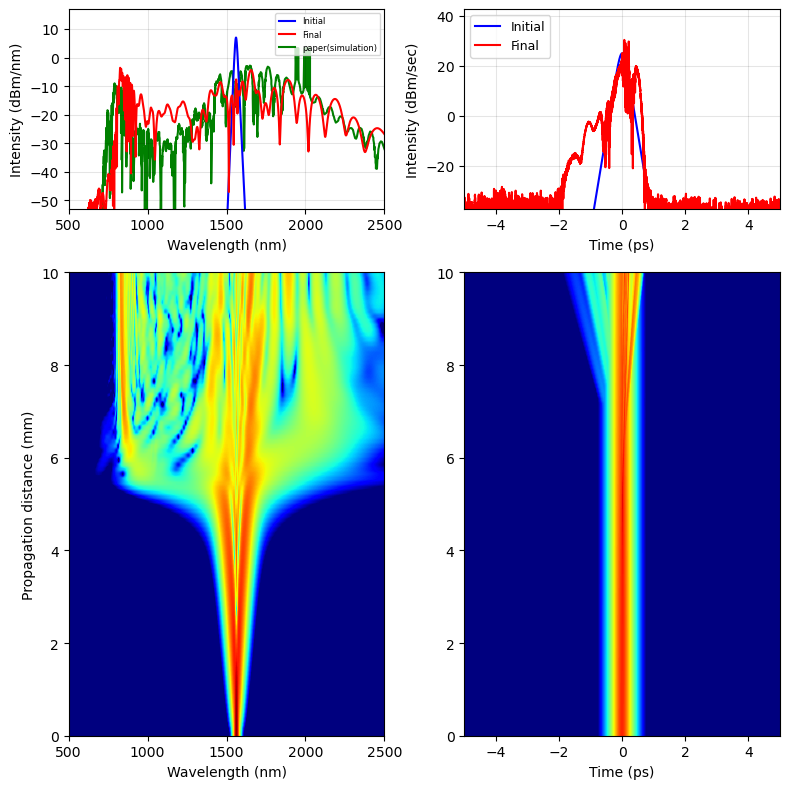

In [33]:
import laserfun as lf
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd
from scipy.interpolate import UnivariateSpline
from scipy.constants import speed_of_light as c

# pulse parameters
FWHM = 200 * 1e-3  # pulse duration (ps)
pulseWL = 1560  # pulse central wavelength (nm)
length = 10 *1e-3

power = 4000  # W
GDD = False  # Group delay dispersion (ps^2)
TOD = False  # Third order dispersion (ps^3)
FOD = False  # Fourth order dispersion
rep_rate = 80 * 1e6 # rep rate in hz
# simulation parameters
Window = 10  # simulation window (ps)
Steps = 100  # simulation steps
Points = 2 ** 14  # simulation points
rtol = 1e-4  # relative error for NLSE integrator
atol = 1e-4 # absolute error
Raman = False  # Enable Raman effect?
Steep = True  # Enable self steepening?

ray = "o"
top_width = 1.75  # um
box_height = 5
triangle_height = 0.6
# ----------- Build Waveguide -----------
n2 = 1e-19  # m^2/W n2 is the nonlinear refractive index at the center
Alpha = 0.16  # loss (dB/cm)

data = np.load(f"data_h_{triangle_height}_w_{top_width}_{ray}.npz")
wls = data['wls']
neff_list = data['neff_list_te']
aeff_list = data['aeff_list_te']


def disp_function(z=0):  # provide effective index to the NLSE
    return (wls, neff_list)


# Calculate Gamma
def gamma_function(pump_wl, wl):  # provide the nonlinearity at the pump to the NLSE
    aeff_interp = scipy.interpolate.interp1d(wls, aeff_list, fill_value= (aeff_list[0], aeff_list[-1]), bounds_error = False)
    gamma = 2 * np.pi * n2 / (wl * 1e-9 * aeff_interp(wl) * 1e-12)
    return gamma
gamma = gamma_function(pulseWL, pulseWL)
#wavelength_grid = np.linspace(pulseWL*0.25, pulseWL*4, Points)
#gamma = gamma_function(wavelength_grid, wavelength_grid)


# create the pulse:
p = lf.Pulse(pulse_type='sech', fwhm_ps=FWHM, center_wavelength_nm=pulseWL,
             time_window_ps=Window, power_is_avg=False, power=power, GDD=GDD, TOD=TOD, FOD=FOD,
             npts=Points)
p.add_noise()
print(f"{p.f_THz[0]}, {p.f_THz[-1]}")
# create the waveguide
f = lf.Fiber(length, center_wl_nm=pulseWL, dispersion_format='GVD',
             gamma_W_m=gamma, loss_dB_per_m=Alpha * 100)

f.set_dispersion_function(disp_function, dispersion_format='n')

# propagate the pulse using the NLSE
results = lf.NLSE(p, f, raman=Raman, shock=Steep, nsaves=Steps, rtol=rtol,
                  atol=atol, print_status=True)
fig, axes = results.plot(wavelength=True, show=False, tlim=(-5, 5), flim=(500,2500), units="dBm/nm",rep_rate= rep_rate, cparam = [50, 60])

#------------- Plot reference -----------
ref = pd.read_csv(
    "../reference_data/Figure2.csv", dtype=np.float64
)
ref_x, ref_y = np.split(ref.values, 2, axis=1)

axes[0][0].plot(ref_x, ref_y + 15, c="green", label="paper(simulation)", zorder=0)
axes[0][0].legend(loc="upper right", prop={'size': 6},fontsize=8)

plt.set_cmap('jet')
plt.show()


Propagate laser to the waveguide using pynlo

1.4084362939352107e-21
z: 1/100
z: 2/100
Discarded
Discarded
z: 3/100
z: 4/100
z: 5/100
z: 6/100
z: 7/100
z: 8/100
z: 9/100
z: 10/100
z: 11/100
z: 12/100
z: 13/100
z: 14/100
z: 15/100
z: 16/100
z: 17/100
z: 18/100
z: 19/100
z: 20/100
z: 21/100
z: 22/100
z: 23/100
z: 24/100
z: 25/100
z: 26/100
z: 27/100
z: 28/100
z: 29/100
z: 30/100
z: 31/100
z: 32/100
z: 33/100
z: 34/100
z: 35/100
z: 36/100
z: 37/100
z: 38/100
z: 39/100
z: 40/100
z: 41/100
z: 42/100
z: 43/100
z: 44/100
z: 45/100
z: 46/100
z: 47/100
z: 48/100
z: 49/100
z: 50/100
z: 51/100
z: 52/100
z: 53/100
z: 54/100
z: 55/100
z: 56/100
z: 57/100
z: 58/100
z: 59/100
z: 60/100
z: 61/100
z: 62/100
z: 63/100
Discarded
z: 64/100
z: 65/100
z: 66/100
z: 67/100
z: 68/100
z: 69/100
z: 70/100
z: 71/100
z: 72/100
z: 73/100
z: 74/100
z: 75/100
z: 76/100
z: 77/100
z: 78/100
z: 79/100
z: 80/100
z: 81/100
z: 82/100
z: 83/100
z: 84/100
z: 85/100
z: 86/100
z: 87/100
z: 88/100
z: 89/100
z: 90/100
z: 91/100
z: 92/100
z: 93/100
z: 94/100
z: 95/100
z: 96/

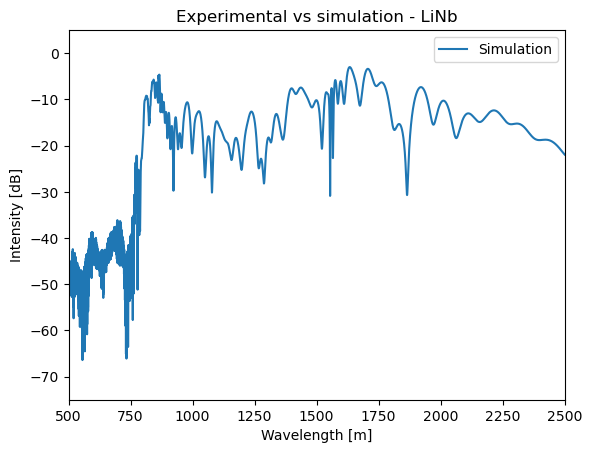

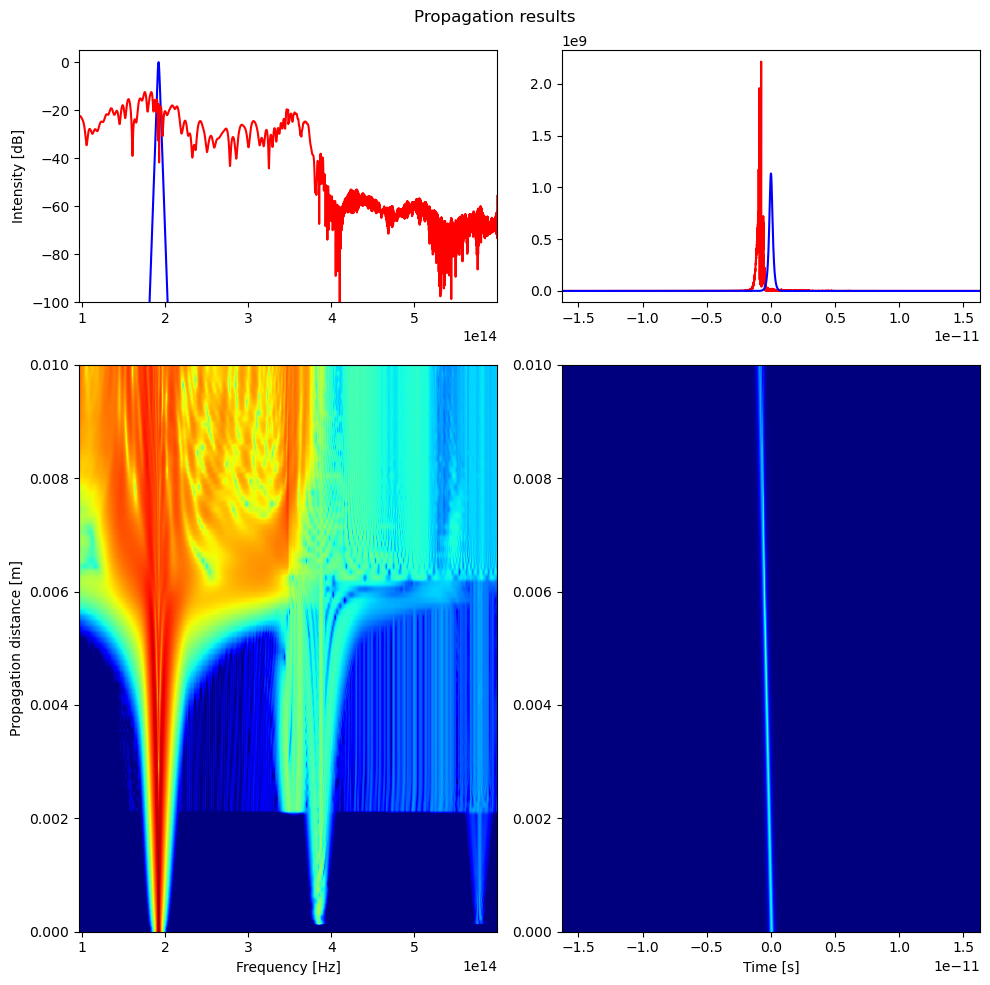

<Figure size 640x480 with 0 Axes>

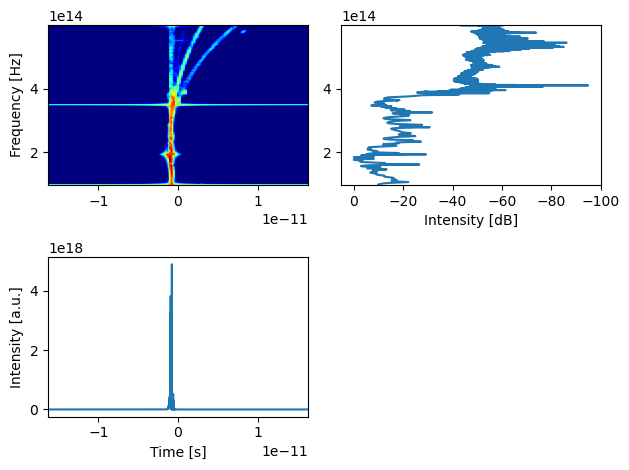

In [58]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import c

import pychi
eps_0 = 8.8541878128e-12

"""
User parameters
"""
### Simulation
t_pts = 2**14

### Light
pulse_duration = 200 * 1e-15
pulse_wavelength = 1.56e-06
pulse_power = 4000
pulse_energy = pulse_power * pulse_duration*0.88

###Load data
ray = "o"
top_width = 1.75  # um
triangle_height = 0.6

data = np.load(f"data_h_{triangle_height}_w_{top_width}_{ray}.npz")
wg_freq = c/(data['wls'] * 1e-9)
wg_neff = data['neff_list_te']
aeff_list = data['aeff_list_te']* 1e-12

aeff_interp = scipy.interpolate.interp1d(data['wls']*1e-9, aeff_list)
neff_interp = scipy.interpolate.interp1d(wg_freq, wg_neff)
wg_aeff = aeff_interp(pulse_wavelength) 


### Waveguide
wg_length = 10 *1e-3
wg_chi_2 = 8.4e-12
n2 = 1e-19 
def wg_chi_3(z, freq):
    return 4/3 *neff_interp(freq)**2 * c * n2 * eps_0 
print(wg_chi_3(0,c/pulse_wavelength))

### Prepare waveguide
waveguide = pychi.materials.Waveguide(wg_freq, wg_neff, wg_chi_2, wg_chi_3,
                                wg_aeff, wg_length, t_pts=t_pts)

### Prepare input pulse
pulse = pychi.light.Sech(waveguide, pulse_duration, pulse_energy, pulse_wavelength)

### Prepare model
model = pychi.models.SpmChi2Chi3(waveguide, pulse)


### Prepare solver, solve
solver = pychi.solvers.Solver(model, z_pts=100)
solver.solve()

"""
Plots
"""
def dBm(num):
    with np.errstate(divide='ignore'):
        return 10 * np.log10(np.abs(num)/np.log10(np.amax(num)))

plt.figure()
plt.plot(pulse.wl *1e9, 20*np.log10(pulse.spectrum_wl[-1]/np.amax(pulse.spectrum_wl[-1]))-3)
plt.xlim(500, 2500)
plt.ylim(-75, 5)
plt.title('Experimental vs simulation - LiNb')
plt.xlabel('Wavelength [m]')
plt.ylabel('Intensity [dB]')
plt.legend(('Simulation', 'Experiment'))
plt.savefig('Experimental_vs_simulation_LiNb.png')

#------------- Plot reference -----------
pulse.plot_propagation("pychi")
# Results can also be accessed via pulse.z_save, pulse.freq, pulse.spectrum, pulse.waveform
# The refractive index and GVD can be seen with waveguide.plot_refractive_index()

C:\Users\eliza\AppData\Local\Temp\ipykernel_28848\1298542084.py:39: RuntimeWarning: divide by zero encountered in log10
  return 10*np.log10(np.abs(num))


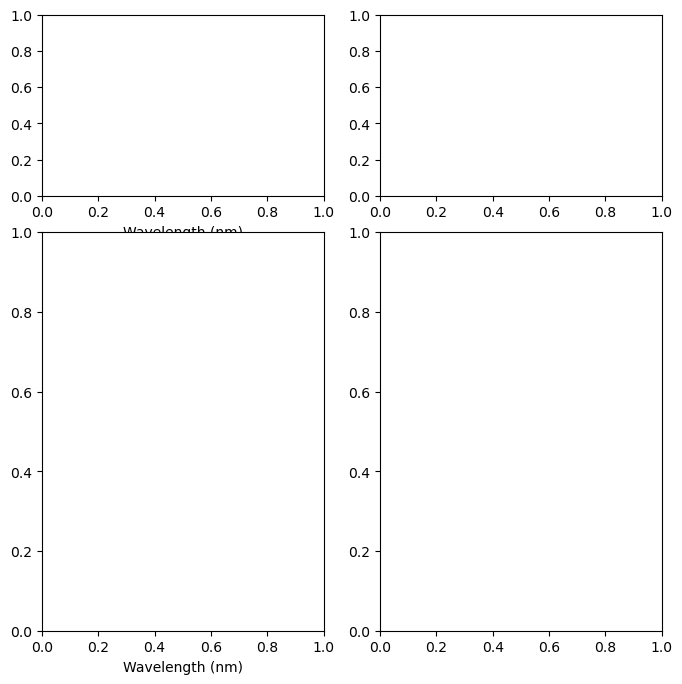

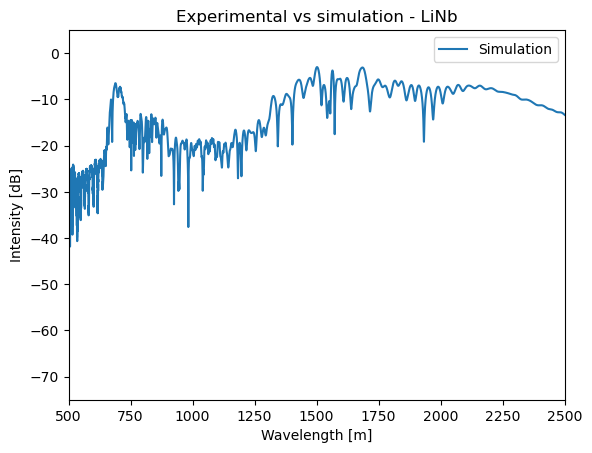

<Figure size 640x480 with 0 Axes>

In [53]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import c
import scipy
import pandas as pd
import pychi
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import c

import pychi
eps_0 = 8.8541878128e-12



def plot_result(pulse, flim=30, tlim=50, margin=0.2, wavelength=True, cparam=[40,80]):

    fig = plt.figure(figsize=(8, 8))
    ax0 = plt.subplot2grid((3, 2), (0, 0), rowspan=1)
    ax1 = plt.subplot2grid((3, 2), (0, 1), rowspan=1)
    ax2 = plt.subplot2grid((3, 2), (1, 0), rowspan=2, sharex=ax0)
    ax3 = plt.subplot2grid((3, 2), (1, 1), rowspan=2, sharex=ax1)

    z = np.linspace(0,10,100) # convert to mm
    
    funits = 'dBm'
    tunits = 'dBm'

    if wavelength:
        ax0.set_xlabel('Wavelength (nm)')
        ax2.set_xlabel('Wavelength (nm)')

    else:
        ax0.set_xlabel('Frequency (THz)')
        ax2.set_xlabel('Frequency (THz)')
    
        
    def dBm(num):
        return 10*np.log10(np.abs(num))
    
    data = np.load("test.npz")
    f = data['f']
    t = data['t']
    IW= dBm(np.abs(data['IW']))
    IT = dBm(data['IT'])
    
    
    ax0.plot(f, dBm(IW[0]), color='b', label='Initial')
    ax1.plot(t, IT[0], color='b', label='Initial')
    ax0.plot(f, IW[-1], color='r', label='Final')
    ax1.plot(t, IT[-1], color='r', label='Final')

    ax1.legend(loc='upper left', fontsize=9)

    ax1.set_xlabel('Time (ps)')

    ax0.set_ylabel('Intensity (%s)' % funits)
    ax1.set_ylabel('Intensity (%s)' % tunits)
    
    # when plotting in dB units, the plots look best if we set cmin to the
    # max value minus about 40 to 80 dB:
    chif = np.max(IW)
    clof = np.max(IW) - cparam[0]
    chit = np.max(IT)
    clot = np.max(IT)- cparam[1]
    ylof = clof - 10
    yhif = chif + 10
    ylot = clot - 10
    yhit = chit + 10
    ax0.set_ylim(ylof, yhif)
    ax1.set_ylim(ylot, yhit)

    ax2.set_ylabel('Propagation distance (mm)')

    extf = (np.min(f), np.max(f), np.min(z), np.max(z))
    extt = (np.min(t), np.max(t), np.min(z), np.max(z))

    ax2.imshow(IW, extent=extf, clim=(clof, chif), aspect='auto',
               origin='lower')
    ax3.imshow(IT, extent=extt, clim=(clot, chit), aspect='auto',
               origin='lower')

    ax3.set_xlabel('Time (ps)')

    fig.tight_layout()

    # set xlims:
    def find_width_and_center(x, y, offset=10):
        def find_roots(x, y):
            s = np.abs(np.diff(np.sign(y))).astype(bool)
            return x[:-1][s] + np.diff(x)[s]/(np.abs(y[1:][s]/y[:-1][s])+1)

        try:
            roots = find_roots(x, y - np.max(y) + offset)
            width = np.max(roots) - np.min(roots)
            center = (np.max(roots) + np.min(roots)) * 0.5

        except:
            width = np.max(x) - np.min(x)
            center = (np.max(x) + np.min(x)) * 0.5

        return width, center

    if not hasattr(flim, "__len__"):
        w, c = find_width_and_center(f, IW[-1], flim)
        flim = (c - 0.5*w*(1 + margin), c + 0.5*w*(1 + margin))

    if not hasattr(tlim, "__len__"):
        w, c = find_width_and_center(t, IT[-1], tlim)
        tlim = (c - 0.5*w*(1 + margin), c + 0.5*w*(1 + margin))

    ax2.set_xlim(flim[0], flim[1])
    ax3.set_xlim(tlim[0], tlim[1])

    for ax in (ax0, ax1):
        ax.grid(alpha=0.1, color='k')

    axs = np.array([[ax0, ax1], [ax2, ax3]])
    return fig, axs
plot_result(None, wavelength=True, tlim=(-5, 5), flim=(500,2500))


plt.set_cmap('jet')
plt.show()
